# Image Classification of COVID-19 X-rays
# Task 2

## Data



* The data foder has the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##  Binary Classification: COVID-19 vs. Normal

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0-rc3'

#### Load Image Data

In [0]:
#DATA_LIST = os.listdir("/content/drive/My Drive/Tasks/Data/all/train")
#DATASET_PATH  = '/content/drive/My Drive/Tasks/Data/all/train'
#TEST_DIR =  '/content/drive/My Drive/Tasks/Data/all/test'
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 20
LEARNING_RATE = 0.001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip = True,
                                   fill_mode='constant')


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_batches = train_datagen.flow_from_directory(DATASET_PATH, target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  seed=42,
                                                  class_mode="categorical")

valid_batches = valid_datagen.flow_from_directory(TEST_DIR, 
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True, 
                                                  batch_size=BATCH_SIZE,
                                                  seed=42,
                                                  class_mode="categorical")

Found 270 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [0]:
NO_TRAIN_SAMPLES = len(train_batches.filenames)
NO_TEST_SAMPLES = len(valid_batches.filenames)

#### Build Model
Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [27]:
# Example Model Implementation
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout


resnet = ResNet50(weights = 'imagenet', 
               include_top = False, 
               input_shape=(224, 224, 3))
resnet.trainable = False

covid_model = Sequential()
covid_model.add(resnet)
covid_model.add(GlobalAveragePooling2D())
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dropout(0.5))
covid_model.add(Dense(NUM_CLASSES, activation="softmax"))

covid_model.summary()

covid_model.compile(optimizer='adam',
                    loss="categorical_crossentropy", 
                    metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 23,719,108
Trainable params: 131,396
Non-trainable params: 23,587,712
_________________________________________________________________


####  Train Model

In [28]:
history = covid_model.fit_generator(train_batches, 
                              epochs=NUM_EPOCHS, 
                              verbose=1, 
                              steps_per_epoch = NO_TRAIN_SAMPLES // BATCH_SIZE,
                              validation_data = valid_batches,
                              validation_steps = NO_TEST_SAMPLES // BATCH_SIZE)

Epoch 1/20
33/33 [==============================] - 8s 242ms/step - loss: 1.4883 - accuracy: 0.4198 - val_loss: 0.7334 - val_accuracy: 0.7500
Epoch 2/20
33/33 [==============================] - 7s 219ms/step - loss: 0.8523 - accuracy: 0.6489 - val_loss: 0.5939 - val_accuracy: 0.7812
Epoch 3/20
33/33 [==============================] - 7s 221ms/step - loss: 0.8320 - accuracy: 0.6260 - val_loss: 0.7038 - val_accuracy: 0.5938
Epoch 4/20
33/33 [==============================] - 7s 210ms/step - loss: 0.7047 - accuracy: 0.6374 - val_loss: 0.5986 - val_accuracy: 0.7188
Epoch 5/20
33/33 [==============================] - 7s 213ms/step - loss: 0.7387 - accuracy: 0.6374 - val_loss: 0.6306 - val_accuracy: 0.7188
Epoch 6/20
33/33 [==============================] - 8s 235ms/step - loss: 0.6465 - accuracy: 0.7481 - val_loss: 0.5304 - val_accuracy: 0.7188
Epoch 7/20
33/33 [==============================] - 7s 210ms/step - loss: 0.6579 - accuracy: 0.7061 - val_loss: 0.6669 - val_accuracy: 0.7500
Epoch 

####  Plot Accuracy and Loss During Training

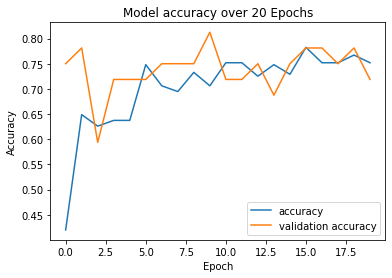

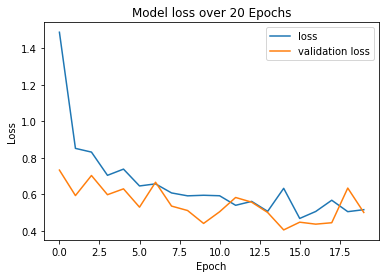

In [29]:
import matplotlib.pyplot as plt

#Plotting Accuracy
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.title('Model accuracy over 20 Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

#Plotting Loss
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.title('Model loss over 20 Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Plot Test Results

Found 36 images belonging to 4 classes.
18/18 [==============================] - 1s 29ms/step
covid/nejmoa2001191_f3-PA.jpeg


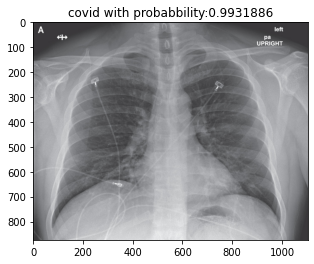

covid/nejmoa2001191_f4.jpeg


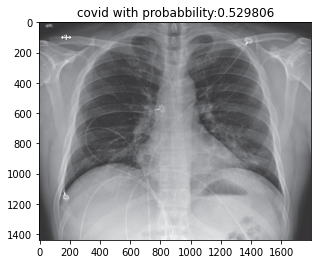

covid/nejmoa2001191_f5-PA.jpeg


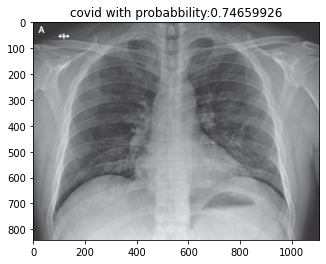

covid/radiol.2020200490.fig3.jpeg


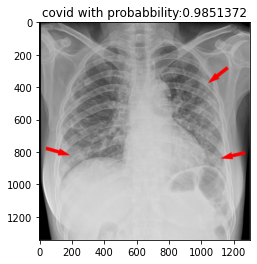

covid/ryct.2020200028.fig1a.jpeg


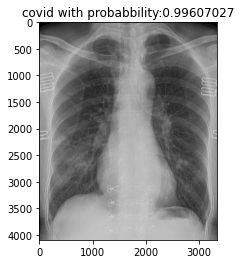

covid/ryct.2020200034.fig2.jpeg


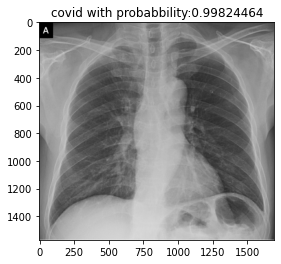

covid/ryct.2020200034.fig5-day0.jpeg


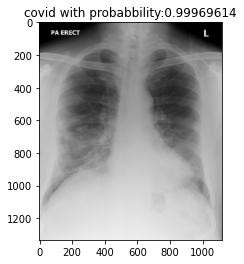

covid/ryct.2020200034.fig5-day4.jpeg


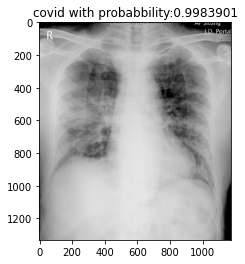

covid/ryct.2020200034.fig5-day7.jpeg


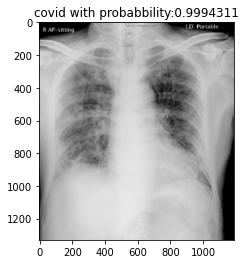

normal/NORMAL2-IM-1385-0001.jpeg


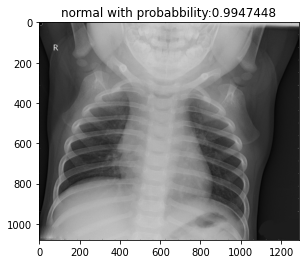

normal/NORMAL2-IM-1396-0001.jpeg


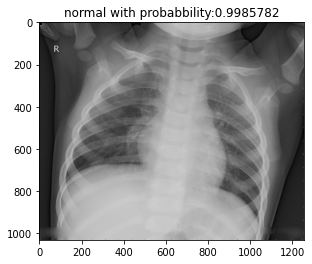

normal/NORMAL2-IM-1400-0001.jpeg


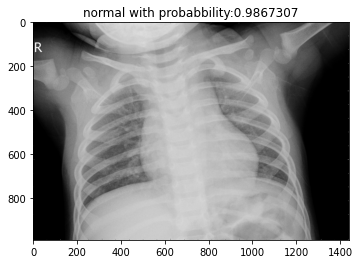

normal/NORMAL2-IM-1401-0001.jpeg


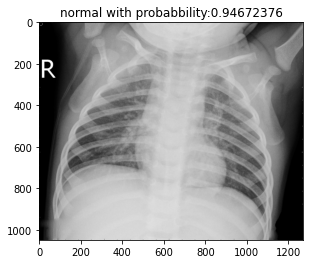

normal/NORMAL2-IM-1406-0001.jpeg


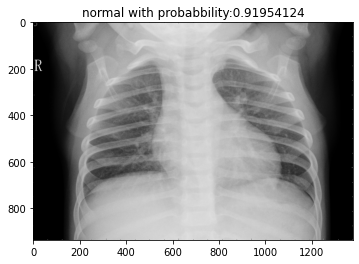

normal/NORMAL2-IM-1412-0001.jpeg


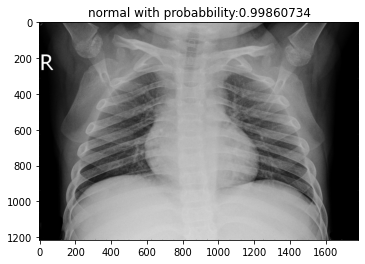

normal/NORMAL2-IM-1419-0001.jpeg


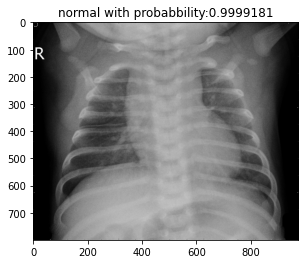

normal/NORMAL2-IM-1422-0001.jpeg


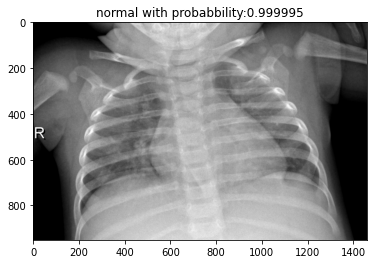

normal/NORMAL2-IM-1423-0001.jpeg


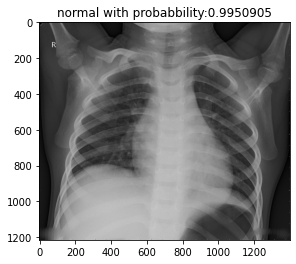

In [30]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=1,
                                                  seed=42,
                                                  class_mode="categorical", shuffle=False)
eval_generator.reset()

ind_class = dict((v,k) for k,v in eval_generator.class_indices.items())

pred = covid_model.predict_generator(eval_generator, 18, verbose=1)

for index, probability in enumerate(pred):

    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)

    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])

    cls = np.argmax(probability)
    plt.title(ind_class[cls]+ " with probabbility:"+str(probability[cls]))
    
    plt.show()

##  TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [31]:
from sklearn.manifold import TSNE
tsne_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

tsne_generator = tsne_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=1,
                                                  seed=42,
                                                  class_mode="categorical", shuffle=False)



intermediate_layer_model = Model(inputs=covid_model.input,
                                 outputs=covid_model.layers[-3].output)


pred = intermediate_layer_model.predict_generator(tsne_generator,  
                                                  verbose=1, steps=NO_TRAIN_SAMPLES)

Found 270 images belonging to 4 classes.
270/270 [==============================] - 6s 21ms/step


In [0]:
pred_emb = TSNE(n_components=2).fit_transform(pred)

In [33]:
df = pd.DataFrame(pred_emb, columns=["x1", "x2"])
df.head()

,x1,x2
0,22.710649,-15.588922
1,20.689440,-15.617099
2,20.715725,-12.643694
3,21.238691,-13.022123
4,20.808994,-12.882045


In [34]:
df.shape

(270, 2)

In [0]:
df["labels"] = [ind_class[val] for val in list(tsne_generator.classes)]

In [1]:
sns.scatterplot(x="x1", y="x2", data=df, hue="labels")
plt.title("t-SNE Visualization")
plt.show()

NameError: ignored

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->